In [74]:
# Libraries

import os
import pandas as pd
from glob import glob
import nibabel as nib
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [75]:
def path(ssd_loc):
    dir_path = os.path.join(base_location, ssd_loc)
    return dir_path

base_location = '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection'

In [76]:
# Import csv files

train_df = pd.read_csv(path('train.csv'))
train_bbox = pd.read_csv(path('train_bounding_boxes.csv'))
test_df = pd.read_csv(path('test.csv'))
ss = pd.read_csv(path('sample_submission.csv'))

print('train shape:', train_df.shape)
print('train bbox shape:', train_bbox.shape)
print('test shape:', test_df.shape)
print('ss shape:', ss.shape)
print('')

train_df.head(3)

train shape: (2019, 9)
train bbox shape: (7217, 6)
test shape: (3, 3)
ss shape: (3, 2)



,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0


In [77]:
seg_paths = glob(f"{base_location}/segmentations/*")
seg_df = pd.DataFrame({'path': seg_paths})
seg_df['StudyInstanceUID'] = seg_df['path'].apply(lambda x:x.split('/')[-1][:-4])
seg_df = seg_df[['StudyInstanceUID','path']]
print('seg_df shape:', seg_df.shape)
seg_df.head(3)

seg_df shape: (87, 2)


,StudyInstanceUID,path
0,1.2.826.0.1.3680043.10633,/Volumes/SSD/rsna-2022-cervical-spine-fracture...
1,1.2.826.0.1.3680043.10921,/Volumes/SSD/rsna-2022-cervical-spine-fracture...
2,1.2.826.0.1.3680043.11827,/Volumes/SSD/rsna-2022-cervical-spine-fracture...


In [78]:
# Metadata was extracted previously (check out my RSNA dataset)
meta_train = pd.read_csv(path('meta_train_clean.csv'))

# Only select patients with segmentations
meta_seg = meta_train[meta_train['StudyInstanceUID'].isin(seg_df['StudyInstanceUID'])].reset_index(drop=True)
print('meta_seg shape:', meta_seg.shape)
meta_seg.head(3)

meta_seg shape: (29832, 8)


,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.0,98.0,314.099976
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.0,98.0,313.599976
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.0,98.0,313.099976


In [79]:

ex_path = path('segmentations/1.2.826.0.1.3680043.12281.nii')
example = nib.load(ex_path)
example = example.get_fdata()  # convert to numpy array
example = example[:, ::-1, ::-1].transpose(2, 1, 0)  # align orientation with train image
np.unique(example[119])

#* 0 ---> background 
#* 2 ---> C2

array([0., 2.])

In [80]:
targets = ['C1','C2','C3','C4','C5','C6','C7']
meta_seg[targets]=0

In [81]:
seg_nib = nib.load(ex_path)
seg = seg_nib.get_fdata()
seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)
num_slices, _, _ = seg.shape
num_slices
mask = seg[200]
unique_vals = np.unique(mask)
unique_vals
UID = seg_df['StudyInstanceUID']

In [82]:
def get_nifti_data():
    for i in tqdm(range(len(seg_df))):
        # Get segmentations for patient
        path = seg_df['path'][i]
        UID = seg_df['StudyInstanceUID'][i]
        seg_nib = nib.load(path)
        seg = seg_nib.get_fdata() # gets all sections of 
        seg = seg[:, ::-1, ::-1].transpose(2, 1, 0) # Align orientation with train images
        num_slices, _, _ = seg.shape
        
        # Loop over slices
        for j in range(num_slices):
            mask = seg[j]
            unique_vals = np.unique(mask)
            
            # Loop over unique values (except 0)
            for k in unique_vals[1:]:
                
                # Ignore thoratic spine etc
                if k <= 7:
                    meta_seg.loc[(meta_seg['StudyInstanceUID']==UID)&(meta_seg['Slice']==j),f'C{int(k)}'] = 1

    # Save extracted targets
    meta_seg.to_csv("meta_segmentation.csv", index=False)
    print('Classification of cervical spine from NIFTI files data saved in meta_segmentation.csv')

In [32]:
# get_nifti_data()

100%|██████████| 87/87 [04:51<00:00,  3.36s/it]


Classification of cervical spine from NIFTI files data saved in meta_segmentation.csv


In [83]:
meta_seg = pd.read_csv(path('meta_segmentation.csv'))
meta_seg.head(3)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.0,98.0,314.099976,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.0,98.0,313.599976,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.0,98.0,313.099976,0,0,0,0,0,0,0


In [84]:
meta_seg[['StudyInstanceUID','Slice']+targets].iloc[199:204,:]

,StudyInstanceUID,Slice,C1,C2,C3,C4,C5,C6,C7
199,1.2.826.0.1.3680043.10633,200,0,1,1,0,0,0,0
200,1.2.826.0.1.3680043.10633,201,0,1,1,0,0,0,0
201,1.2.826.0.1.3680043.10633,202,0,0,1,1,0,0,0
202,1.2.826.0.1.3680043.10633,203,0,0,1,1,0,0,0
203,1.2.826.0.1.3680043.10633,204,0,0,1,1,0,0,0


In [85]:
# Print example of extracted vertebrae
print('UID:', meta_seg['StudyInstanceUID'].unique()[0])
pd.set_option('display.max_rows', 500)
meta_seg[meta_seg['StudyInstanceUID']==meta_seg['StudyInstanceUID'].unique()[0]].loc[110:340,targets]

UID: 1.2.826.0.1.3680043.10633


,C1,C2,C3,C4,C5,C6,C7
110,0,0,0,0,0,0,0
111,1,0,0,0,0,0,0
112,1,0,0,0,0,0,0
113,1,0,0,0,0,0,0
114,1,0,0,0,0,0,0
115,1,0,0,0,0,0,0
116,1,0,0,0,0,0,0
117,1,0,0,0,0,0,0
118,1,0,0,0,0,0,0
119,1,0,0,0,0,0,0


In [86]:
slice_max_seg = meta_seg.groupby('StudyInstanceUID')['Slice'].max().to_dict()
slice_max_seg

{'1.2.826.0.1.3680043.10633': 429,
 '1.2.826.0.1.3680043.10921': 339,
 '1.2.826.0.1.3680043.11827': 208,
 '1.2.826.0.1.3680043.11988': 217,
 '1.2.826.0.1.3680043.12281': 331,
 '1.2.826.0.1.3680043.12292': 341,
 '1.2.826.0.1.3680043.12833': 261,
 '1.2.826.0.1.3680043.1363': 199,
 '1.2.826.0.1.3680043.14267': 473,
 '1.2.826.0.1.3680043.1480': 451,
 '1.2.826.0.1.3680043.15206': 334,
 '1.2.826.0.1.3680043.1542': 428,
 '1.2.826.0.1.3680043.1573': 286,
 '1.2.826.0.1.3680043.16092': 329,
 '1.2.826.0.1.3680043.16919': 409,
 '1.2.826.0.1.3680043.17481': 407,
 '1.2.826.0.1.3680043.17960': 271,
 '1.2.826.0.1.3680043.18480': 462,
 '1.2.826.0.1.3680043.1868': 653,
 '1.2.826.0.1.3680043.18906': 351,
 '1.2.826.0.1.3680043.18935': 325,
 '1.2.826.0.1.3680043.18968': 411,
 '1.2.826.0.1.3680043.19021': 395,
 '1.2.826.0.1.3680043.19333': 205,
 '1.2.826.0.1.3680043.19388': 492,
 '1.2.826.0.1.3680043.20120': 335,
 '1.2.826.0.1.3680043.20647': 263,
 '1.2.826.0.1.3680043.20928': 248,
 '1.2.826.0.1.3680043.213

<div style="font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;">Now since we have different number of slices for different patients as you can see in the dictionary above, we have to genralize/rationalize them inorder to use it properly in machine learning data</p>
</div>

In [87]:
meta_seg['SliceRatio'] = 0
meta_seg['SliceRatio'] = meta_seg['Slice']/meta_seg['StudyInstanceUID'].map(slice_max_seg)

In [88]:
meta_seg.head(10)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,SliceRatio
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.0,98.0,314.099976,0,0,0,0,0,0,0,0.002331
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.0,98.0,313.599976,0,0,0,0,0,0,0,0.004662
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.0,98.0,313.099976,0,0,0,0,0,0,0,0.006993
3,1.2.826.0.1.3680043.10633,4,512,512,1.0,-68.0,98.0,312.599976,0,0,0,0,0,0,0,0.009324
4,1.2.826.0.1.3680043.10633,5,512,512,1.0,-68.0,98.0,312.099976,0,0,0,0,0,0,0,0.011655
5,1.2.826.0.1.3680043.10633,6,512,512,1.0,-68.0,98.0,311.599976,0,0,0,0,0,0,0,0.013986
6,1.2.826.0.1.3680043.10633,7,512,512,1.0,-68.0,98.0,311.099976,0,0,0,0,0,0,0,0.016317
7,1.2.826.0.1.3680043.10633,8,512,512,1.0,-68.0,98.0,310.599976,0,0,0,0,0,0,0,0.018648
8,1.2.826.0.1.3680043.10633,9,512,512,1.0,-68.0,98.0,310.099976,0,0,0,0,0,0,0,0.020979
9,1.2.826.0.1.3680043.10633,10,512,512,1.0,-68.0,98.0,309.599976,0,0,0,0,0,0,0,0.023310


In [89]:
features = ['SliceRatio','SliceThickness','ImagePositionPatient_x','ImagePositionPatient_y','ImagePositionPatient_z']

# Features and targets
X = meta_seg[['StudyInstanceUID']+features]
y = meta_seg[targets]


In [91]:
# Train-valid split, grouped by patient (80/20 split)
gkf = GroupKFold(n_splits=5)
(train_idx, valid_idx) = next(gkf.split(X, y, groups = X['StudyInstanceUID']))

# Train set
X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx,:]

# Validation set
X_valid, y_valid = X.iloc[valid_idx,:], y.iloc[valid_idx,:]

# Drop patient id
X_train = X_train.drop('StudyInstanceUID', axis=1)
X_valid = X_valid.drop('StudyInstanceUID', axis=1)

# Random Forest

Accuracy of C1: 0.9020504999152686 %
Accuracy of C2: 0.8927300457549567 %
Accuracy of C3: 0.900355871886121 %
Accuracy of C4: 0.8957803762074225 %
Accuracy of C5: 0.8842569056092188 %
Accuracy of C6: 0.8695136417556346 %
Accuracy of C7: 0.8542619894933062 %
Overall accuracy: 0.8855641900888469 %



,Feature,Importance
0,SliceRatio,0.577706
4,ImagePositionPatient_z,0.214341
3,ImagePositionPatient_y,0.088484
2,ImagePositionPatient_x,0.088159
1,SliceThickness,0.031310


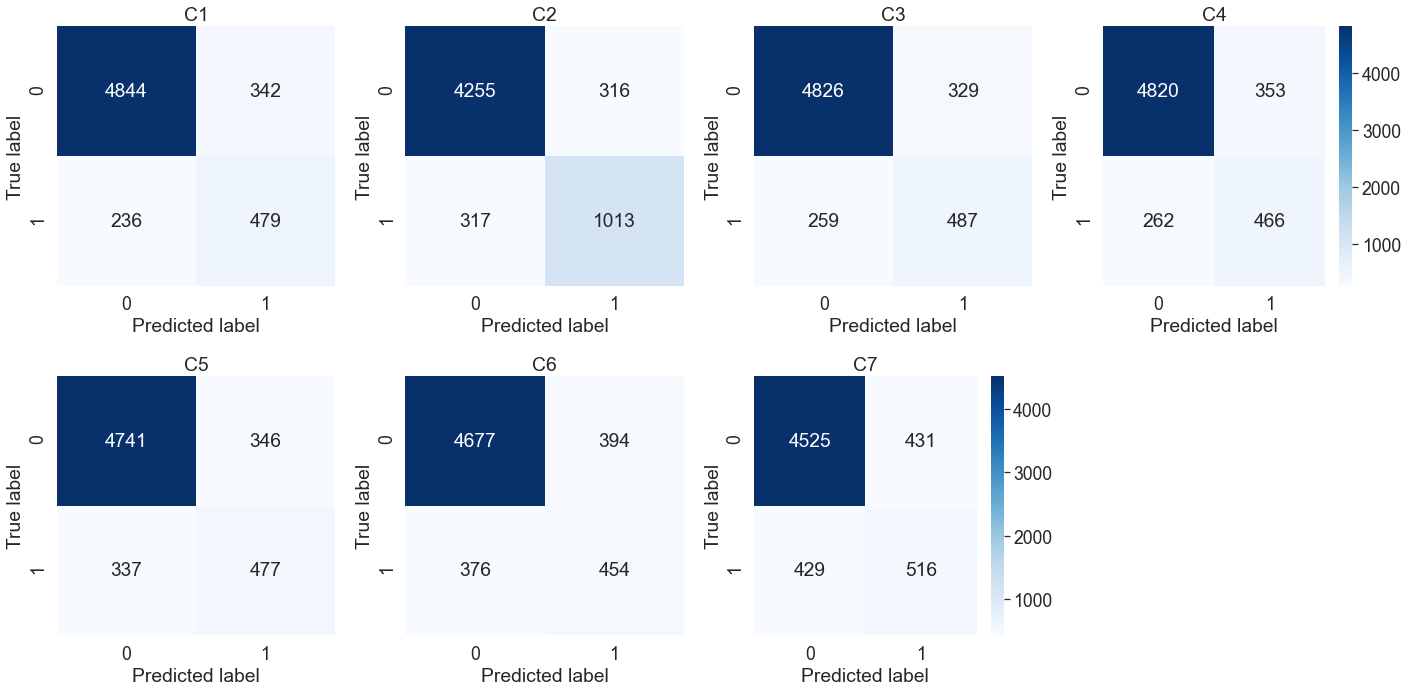

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)

def rf_classifier():
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_valid)
    total_acc = 0 
    for i in range(7):
        acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
        total_acc+=acc/7
        print(f'Accuracy of C{i+1}: {acc} %')
    print(f'Overall accuracy: {total_acc} %\n')
    feature_detection = pd.DataFrame({'Feature':features, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False)
    display(feature_detection)
    preds = clf.predict(X_valid)

    # Confusion matrices
    fig = plt.figure(figsize=(20,10))
    for i in range(7):
        cm = confusion_matrix(preds[:,i], y_valid.values[:,i])
        plt.subplot(2,4,i+1)
        CBAR=False
        if (i==3) or (i==6):
            CBAR=True
        sns.heatmap(cm, annot=True, fmt='d', cbar=CBAR, cmap='Blues')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(f'C{i+1}')
    fig.tight_layout()
    
rf_classifier()

# Decision Tree

Accuracy of C1: 0.8866293848500254 %
Accuracy of C2: 0.8754448398576512 %
Accuracy of C3: 0.8971360786307405 %
Accuracy of C4: 0.8764616166751398 %
Accuracy of C5: 0.8630740552448738 %
Accuracy of C6: 0.8318928995085578 %
Accuracy of C7: 0.8322318251143874 %
Overall accuracy: 0.8661243856973395 %



,Feature,Importance
0,SliceRatio,0.550272
4,ImagePositionPatient_z,0.174099
2,ImagePositionPatient_x,0.109656
3,ImagePositionPatient_y,0.095415
1,SliceThickness,0.070559


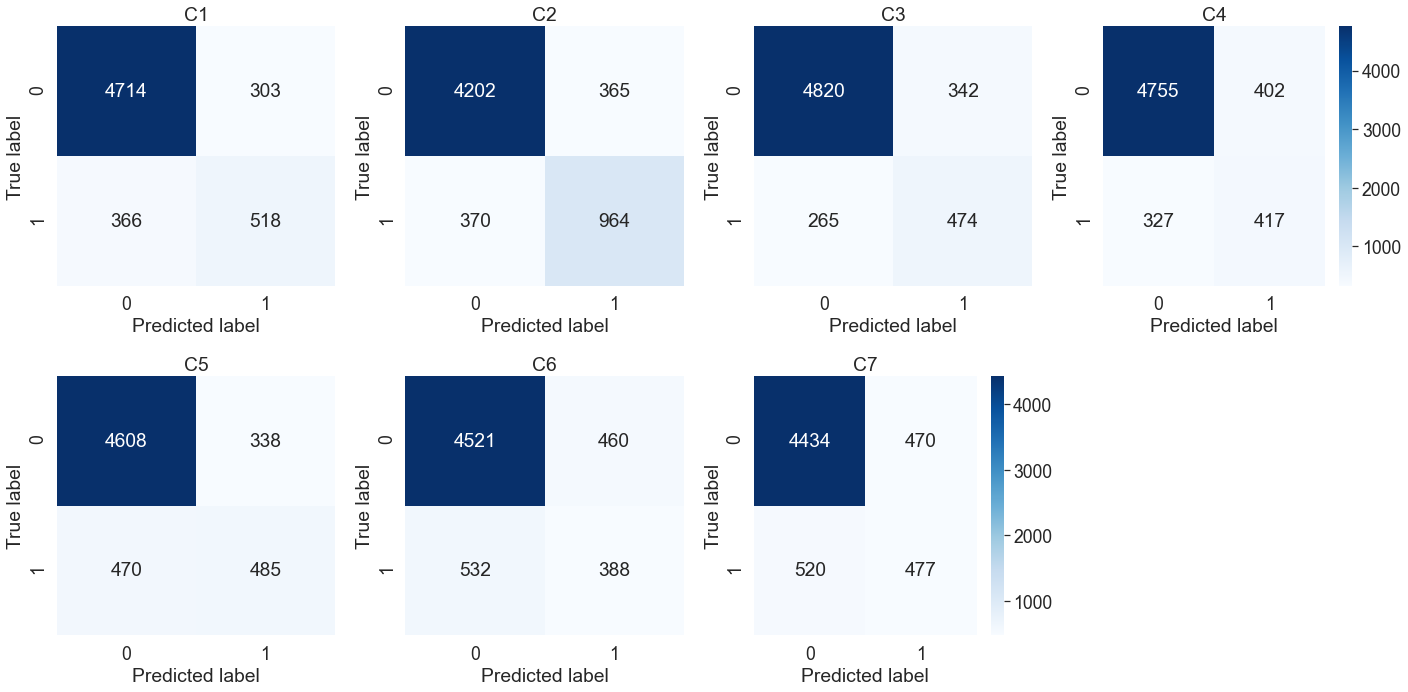

In [112]:
def dt_classifier():
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_valid)
    total_acc = 0 
    for i in range(7):
        acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
        total_acc+=acc/7
        print(f'Accuracy of C{i+1}: {acc} %')
    print(f'Overall accuracy: {total_acc} %\n')
    feature_detection = pd.DataFrame({'Feature':features, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False)
    display(feature_detection)
    preds = clf.predict(X_valid)

    # Confusion matrices
    fig = plt.figure(figsize=(20,10))
    for i in range(7):
        cm = confusion_matrix(preds[:,i], y_valid.values[:,i])
        plt.subplot(2,4,i+1)
        CBAR=False
        if (i==3) or (i==6):
            CBAR=True
        sns.heatmap(cm, annot=True, fmt='d', cbar=CBAR, cmap='Blues')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(f'C{i+1}')
    fig.tight_layout()
    
dt_classifier()

# KNN

Accuracy of C1: 0.7890188103711235 %
Accuracy of C2: 0.7112353838332486 %
Accuracy of C3: 0.787324182341976 %
Accuracy of C4: 0.7856295543128283 %
Accuracy of C5: 0.7898661243856974 %
Accuracy of C6: 0.7754617861379427 %
Accuracy of C7: 0.7391967463141841 %
Overall accuracy: 0.7682475125281429 %



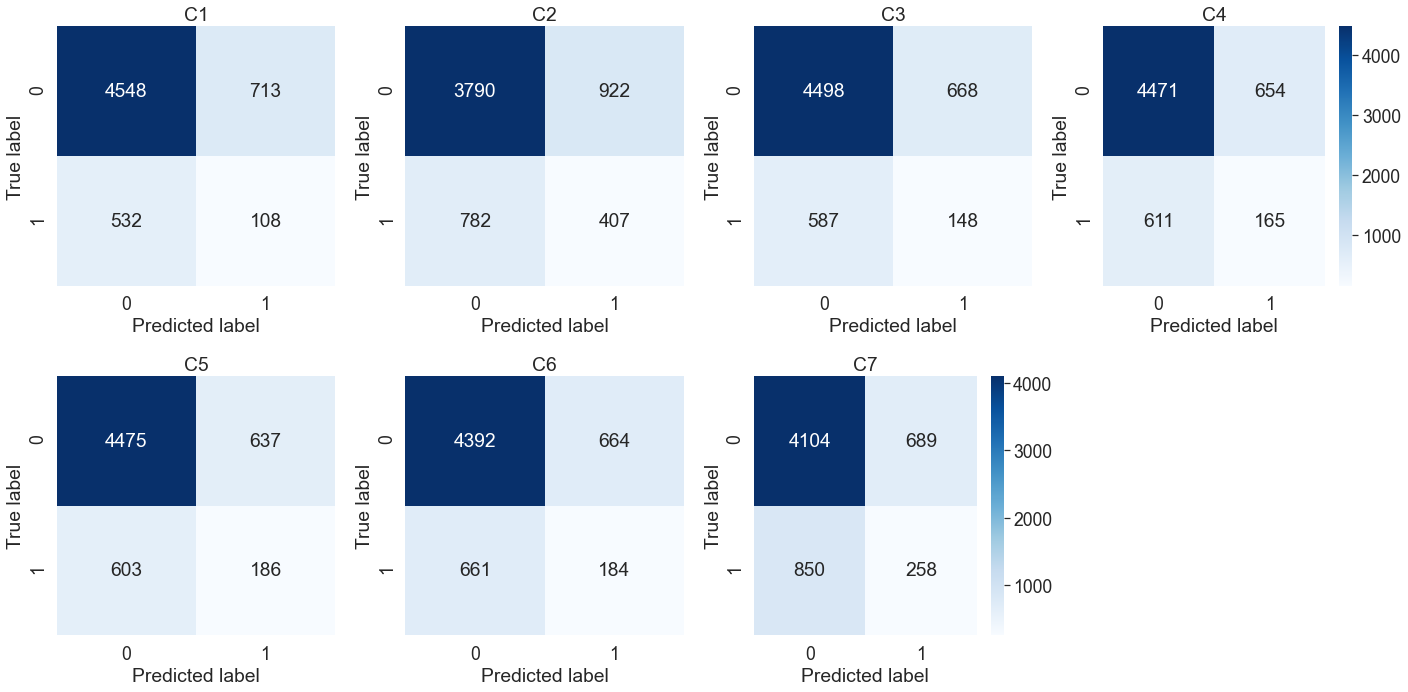

In [116]:
def knn_classifier():
    clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_valid)
    total_acc = 0 
    for i in range(7):
        acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
        total_acc+=acc/7
        print(f'Accuracy of C{i+1}: {acc} %')
    print(f'Overall accuracy: {total_acc} %\n')
    # feature_detection = pd.DataFrame({'Feature':features, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False)
    # display(feature_detection)
    preds = clf.predict(X_valid)

    # Confusion matrices
    fig = plt.figure(figsize=(20,10))
    for i in range(7):
        cm = confusion_matrix(preds[:,i], y_valid.values[:,i])
        plt.subplot(2,4,i+1)
        CBAR=False
        if (i==3) or (i==6):
            CBAR=True
        sns.heatmap(cm, annot=True, fmt='d', cbar=CBAR, cmap='Blues')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(f'C{i+1}')
    fig.tight_layout()
    
knn_classifier()

# XGBOOST

/Users/jarvis/Library/Python/3.8/lib/python/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[03:24:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Overall accuracy: 0.62904592441959 %



,Feature,Importance
0,SliceRatio,0.404515
1,SliceThickness,0.303056
2,ImagePositionPatient_x,0.107980
3,ImagePositionPatient_y,0.097460
4,ImagePositionPatient_z,0.086989


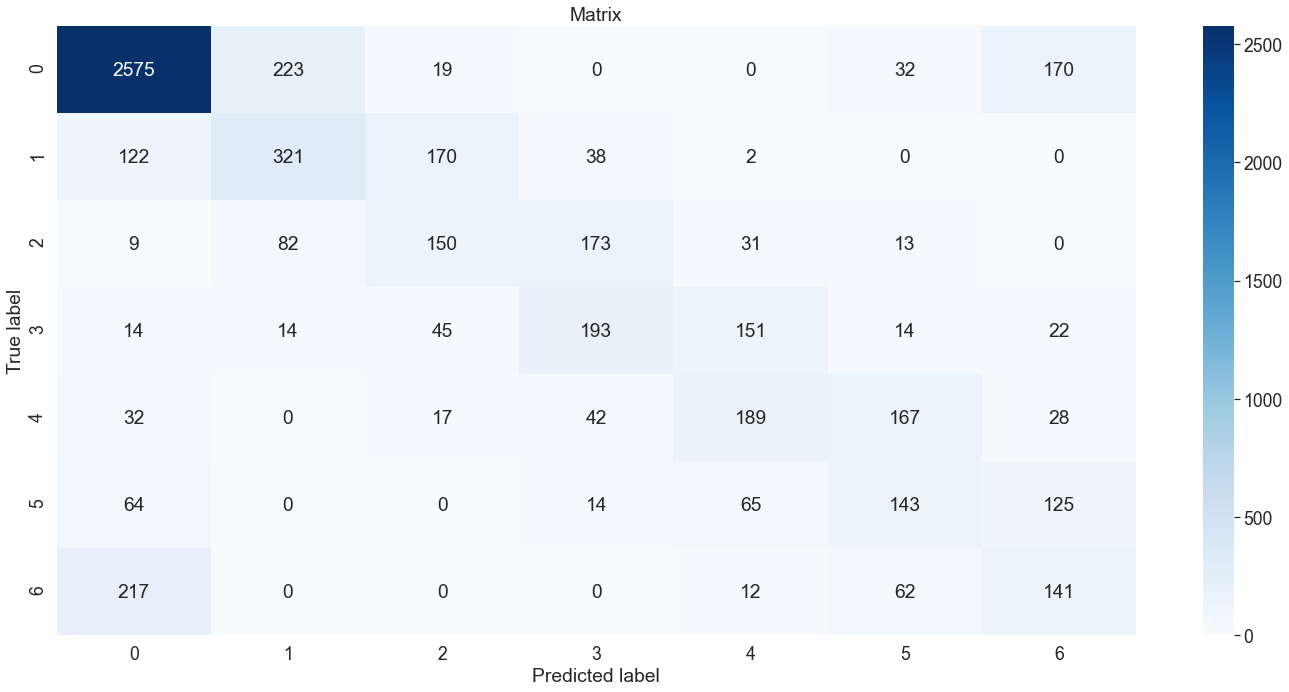

In [121]:
from sklearn.metrics import accuracy_score
def xgb_classifier():
    clf = XGBClassifier()
    y_train_xgb = y_train.apply(lambda x: x.argmax(), axis=1).values
    clf.fit(X_train, y_train_xgb)
    y_preds = clf.predict(X_valid)
    y_valid_xgb = y_valid.apply(lambda x: x.argmax(), axis=1).values
    total_acc = accuracy_score(y_valid_xgb, y_preds)
    # for i in range(7):
    #     acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
    #     total_acc+=acc/7
    #     print(f'Accuracy of C{i+1}: {acc} %')
    print(f'\nOverall accuracy: {total_acc} %\n')
    feature_detection = pd.DataFrame({'Feature':features, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False)
    display(feature_detection)
    preds = clf.predict(X_valid)

    # Confusion matrices
    fig = plt.figure(figsize=(20,10))
    cm = confusion_matrix(preds, y_valid_xgb)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Matrix')
    fig.tight_layout()
    
xgb_classifier()

# SVM


Overall accuracy: 0.5139806812404677 %



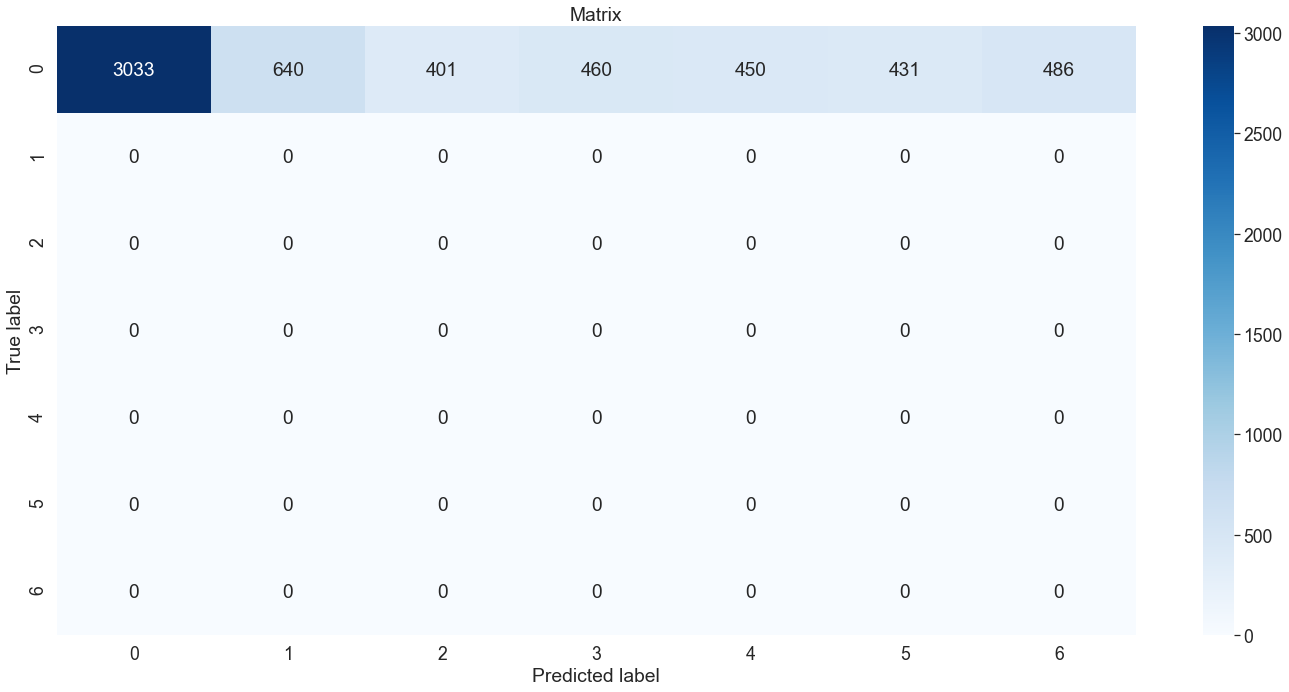

In [124]:
def svm_classifier():
    clf = SVC()
    y_train_svm = y_train.apply(lambda x: x.argmax(), axis=1).values
    clf.fit(X_train, y_train_svm)
    y_preds = clf.predict(X_valid)
    y_valid_xgb = y_valid.apply(lambda x: x.argmax(), axis=1).values
    total_acc = accuracy_score(y_valid_xgb, y_preds)
    # for i in range(7):
    #     acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
    #     total_acc+=acc/7
    #     print(f'Accuracy of C{i+1}: {acc} %')
    print(f'\nOverall accuracy: {total_acc} %\n')
    # feature_detection = pd.DataFrame({'Feature':features, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False)
    # display(feature_detection)
    preds = clf.predict(X_valid)

    # Confusion matrices
    fig = plt.figure(figsize=(20,10))
    cm = confusion_matrix(preds, y_valid_xgb)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Matrix')
    fig.tight_layout()
    
svm_classifier()

# LightGBM


Overall accuracy: 0.6288764616166751 %



,Feature,Importance
0,SliceRatio,7593
4,ImagePositionPatient_z,6168
2,ImagePositionPatient_x,3711
3,ImagePositionPatient_y,2692
1,SliceThickness,836


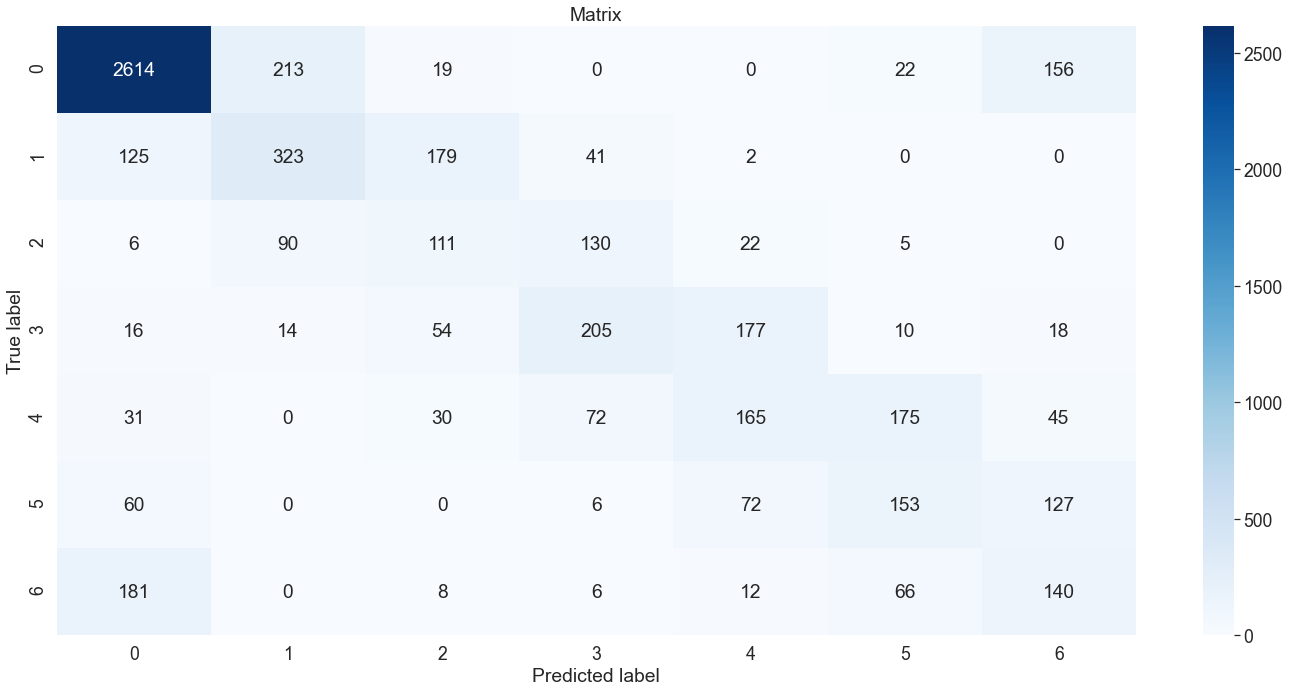

In [126]:
def lgbm_classifier():
    clf = LGBMClassifier()
    y_train_lgbm = y_train.apply(lambda x: x.argmax(), axis=1).values
    clf.fit(X_train, y_train_lgbm)
    y_preds = clf.predict(X_valid)
    y_valid_lgbm = y_valid.apply(lambda x: x.argmax(), axis=1).values
    total_acc = accuracy_score(y_valid_lgbm, y_preds)
    # for i in range(7):
    #     acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
    #     total_acc+=acc/7
    #     print(f'Accuracy of C{i+1}: {acc} %')
    print(f'\nOverall accuracy: {total_acc} %\n')
    feature_detection = pd.DataFrame({'Feature':features, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False)
    display(feature_detection)
    preds = clf.predict(X_valid)

    # Confusion matrices
    fig = plt.figure(figsize=(20,10))
    cm = confusion_matrix(preds, y_valid_lgbm)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Matrix')
    fig.tight_layout()
    
lgbm_classifier()

# CatBoost


Overall accuracy: 0.507371631926792 %



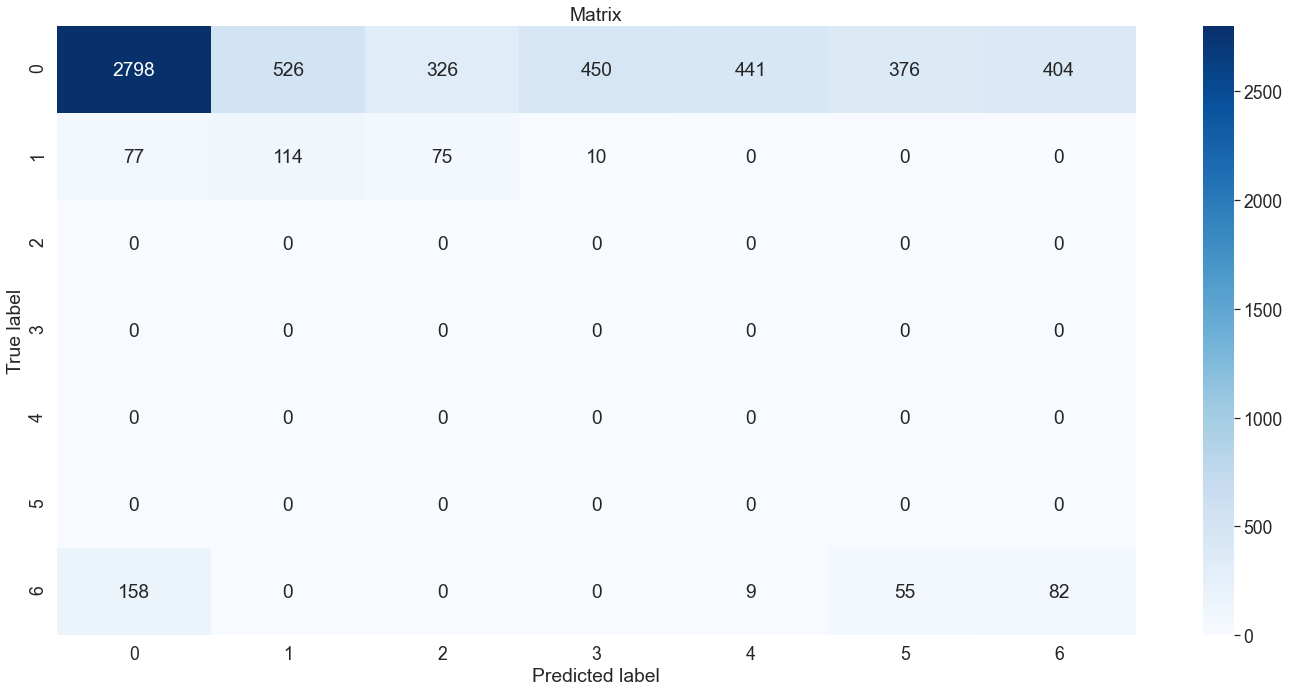

In [131]:
def gaussian_classifier():
    clf = GaussianNB()
    y_train_gaussian = y_train.apply(lambda x: x.argmax(), axis=1).values
    clf.fit(X_train, y_train_gaussian)
    y_preds = clf.predict(X_valid)
    y_valid_gaussian = y_valid.apply(lambda x: x.argmax(), axis=1).values
    total_acc = accuracy_score(y_valid_gaussian, y_preds)
    # for i in range(7):
    #     acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
    #     total_acc+=acc/7
    #     print(f'Accuracy of C{i+1}: {acc} %')
    print(f'\nOverall accuracy: {total_acc} %\n')
    # feature_detection = pd.DataFrame({'Feature':features, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False)
    # display(feature_detection)
    preds = clf.predict(X_valid)

    # Confusion matrices
    fig = plt.figure(figsize=(20,10))
    cm = confusion_matrix(preds, y_valid_gaussian)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Matrix')
    fig.tight_layout()
    
gaussian_classifier()

# Making C1-C7 

In [138]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [139]:
np.set_printoptions(threshold=np.inf)
clf.predict(X.drop('StudyInstanceUID',axis=1))[110:250,:]

array([[1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1,

In [140]:
# Read in metadata for entire train set
meta_train = pd.read_csv(path('meta_train_clean.csv'))

# Calculate slice ratio (to generalise better)
slice_max_train = meta_train.groupby('StudyInstanceUID')['Slice'].max().to_dict()
meta_train['SliceRatio'] = 0
meta_train['SliceRatio'] = meta_train['Slice']/meta_train['StudyInstanceUID'].map(slice_max_train)

# Initialise targets
meta_train[targets]=0

# Predict targets for entire train set
meta_train[targets] = clf.predict(meta_train[features])

# We know images with segmentations have 100% accurate targets so put these back in
meta_train.loc[meta_train['StudyInstanceUID'].isin(meta_seg['StudyInstanceUID']),targets] = meta_seg[targets].values

# Save to csv
meta_train.to_csv('meta_train_with_vertebrae_rf.csv', index=False)

# Preview
meta_train.head(3)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,SliceRatio,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282,0.003731,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657,0.007463,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032,0.011194,0,0,0,0,0,0,0


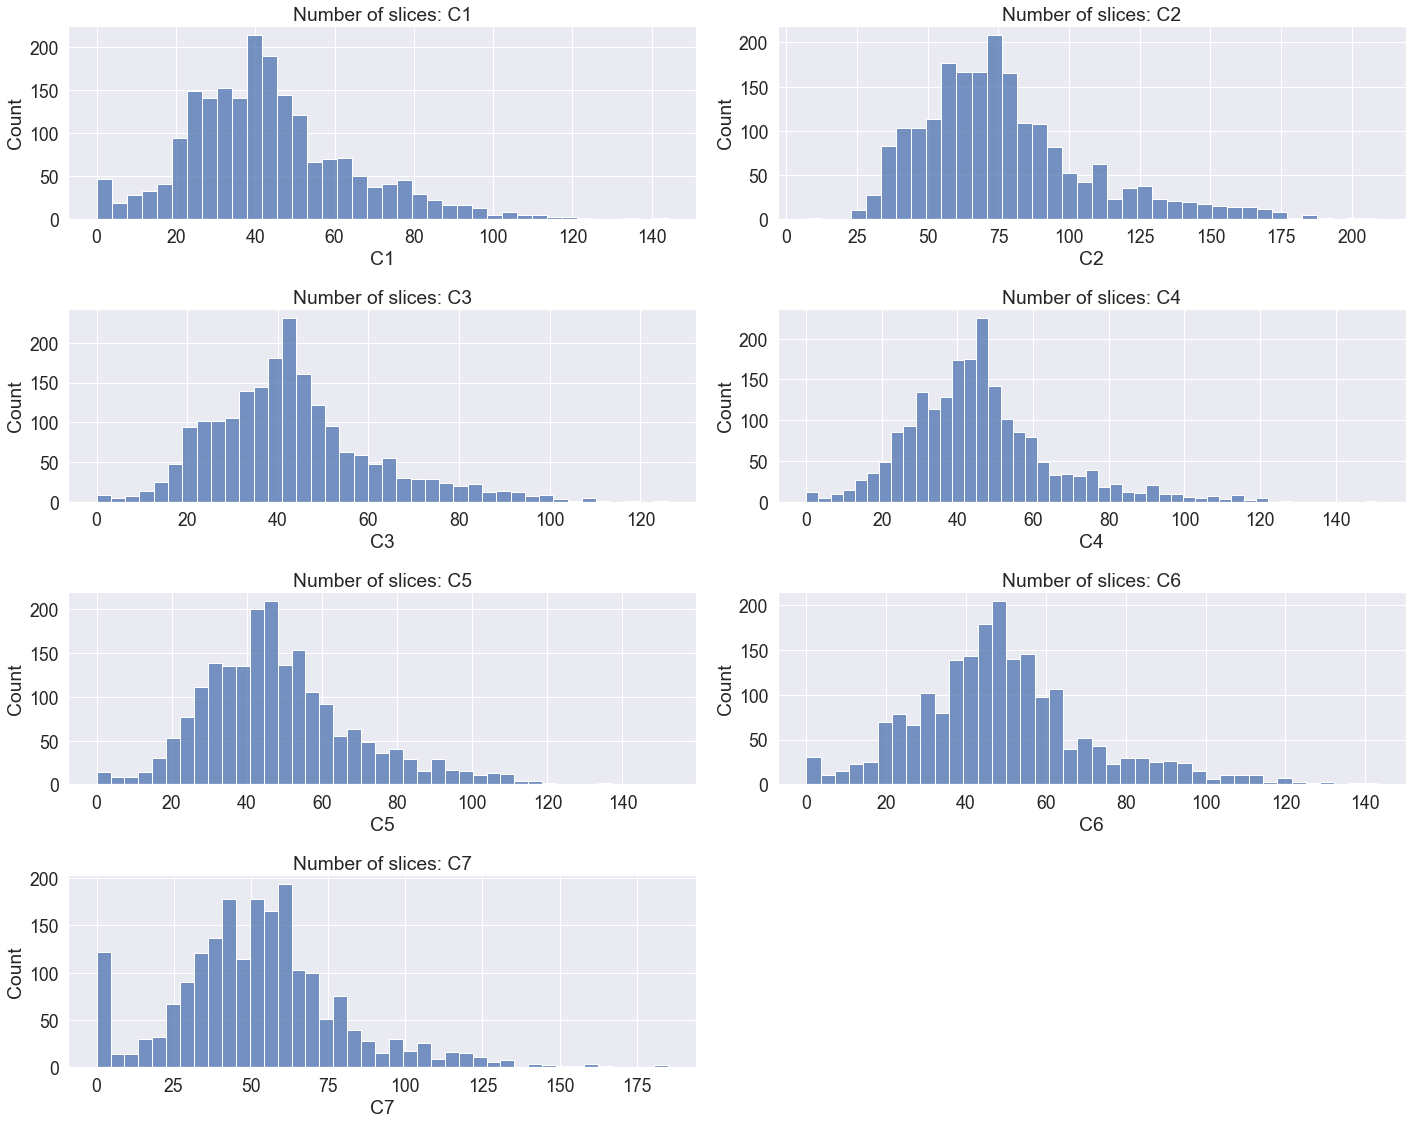

In [141]:
fig = plt.figure(figsize=(20,16))
for i, Cx in enumerate(targets):
    plt.subplot(4,2,i+1)
    sns.histplot(meta_train.groupby('StudyInstanceUID')[Cx].sum())
    plt.title(f'Number of slices: {Cx}')
fig.tight_layout()